In [1]:
! pip install seaborn numba

In [2]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

Tue Jul 11 08:17:31 PM SAST 2023


In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [5]:
# load data from csv file
try:
    df_all = pd.read_csv("data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

Goals of exercise (can be found on https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html#motivation)
-Infer strength of teams based on the scorelines, although it is a noisy measure of strength, latent parameter might provide insight.

## Visualization

In [8]:
df_all.describe()

,home_score,away_score,year
count,60.000000,60.000000,60.000000
mean,23.500000,19.983333,2015.500000
std,14.019962,12.911028,1.127469
min,0.000000,0.000000,2014.000000
25%,16.000000,10.000000,2014.750000
50%,20.500000,18.000000,2015.500000
75%,27.250000,23.250000,2016.250000
max,67.000000,63.000000,2017.000000


In [ ]:
def get_modes(df, feature_list,number_of_modes=2):
    mode_1_values = []
    mode_1_freq = []
    mode_2_values = []
    mode_2_freq = []
    for feature in feature_list:
        modes = df[feature].value_counts()[0:number_of_modes]
        if len(modes) > 1:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(modes.index.values.tolist()[1])
            mode_2_freq.append(modes.values.tolist()[1])
        else:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(None)
            mode_2_freq.append(None)
    return mode_1_values, mode_1_freq, mode_2_values, mode_2_freq#%%
! pip install seaborn numba

In [ ]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

In [ ]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [ ]:
# load data from csv file
try:
    df_all = pd.read_csv("data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

Goals of exercise (can be found on https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html#motivation)
-Infer strength of teams based on the scorelines, although it is a noisy measure of strength, latent parameter might provide insight.

## Visualization

In [10]:
def get_modes(df, feature_list,number_of_modes=2):
    mode_1_values = []
    mode_1_freq = []
    mode_2_values = []
    mode_2_freq = []
    for feature in feature_list:
        modes = df[feature].value_counts()[0:number_of_modes]
        if len(modes) > 1:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(modes.index.values.tolist()[1])
            mode_2_freq.append(modes.values.tolist()[1])
        else:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(None)
            mode_2_freq.append(None)
    return mode_1_values, mode_1_freq, mode_2_values, mode_2_freq

In [11]:
numeric_dqr = df_all.describe(include=np.number).T
numeric_dqr['missing_count'] = df_all.isna().sum()
numeric_dqr['%_missing'] = numeric_dqr['missing_count'] / df_all.count()[1]
numeric_dqr['Card.'] = df_all[numeric_dqr.T.columns.values.tolist()].nunique()
numeric_dqr[['count', '%_missing', 'Card.', 'min', '25%', 'mean', '50%', '75%', 'max', 'std']].rename(columns={'25%': '1st Qtr.', '50%': 'Median', '75%': '3rd Qtr.'})

,count,%_missing,Card.,min,1st Qtr.,mean,Median,3rd Qtr.,max,std
home_score,60.0,0.0,31,0.0,16.00,23.500000,20.5,27.25,67.0,14.019962
away_score,60.0,0.0,31,0.0,10.00,19.983333,18.0,23.25,63.0,12.911028
year,60.0,0.0,4,2014.0,2014.75,2015.500000,2015.5,2016.25,2017.0,1.127469


In [14]:
# Let's look at the tail end of this dataframe
df_all.tail()

,home_team,away_team,home_score,away_score,year
55,Italy,France,18,40,2017
56,England,Scotland,61,21,2017
57,Scotland,Italy,29,0,2017
58,France,Wales,20,18,2017
59,Ireland,England,13,9,2017


In [15]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])

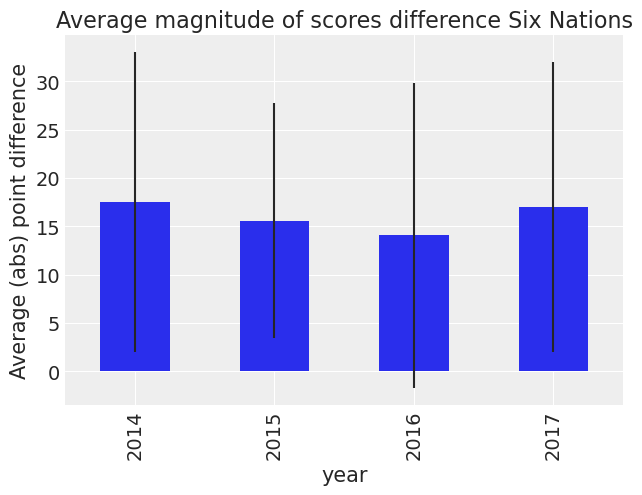

In [16]:
(
    df_all.groupby("year")["difference"]
    .mean()
    .plot(
        kind="bar",
        title="Average magnitude of scores difference Six Nations",
        yerr=df_all.groupby("year")["difference"].std(),
    )
    .set_ylabel("Average (abs) point difference")
);

In [17]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]

In [18]:
df_all.pivot_table("difference_non_abs", "home_team", "year")

year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


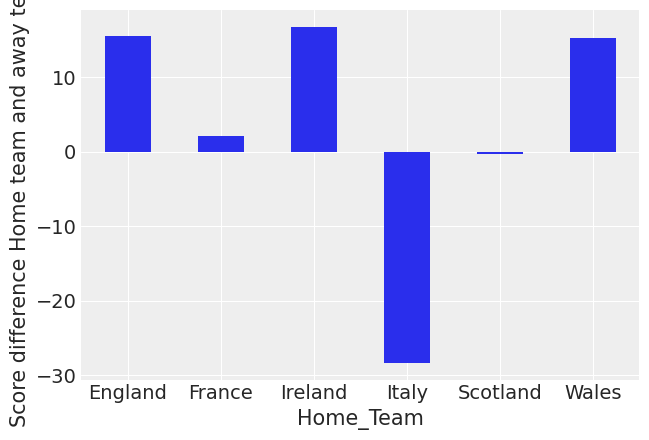

In [19]:
(
    df_all.pivot_table("difference_non_abs", "home_team")
    .rename_axis("Home_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

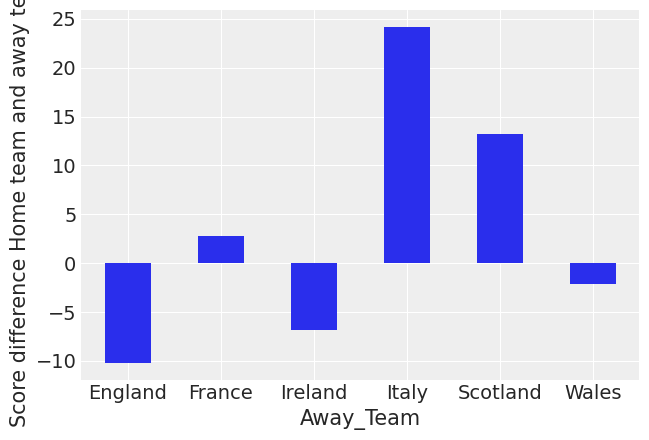

In [20]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

/home/arneau/anaconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


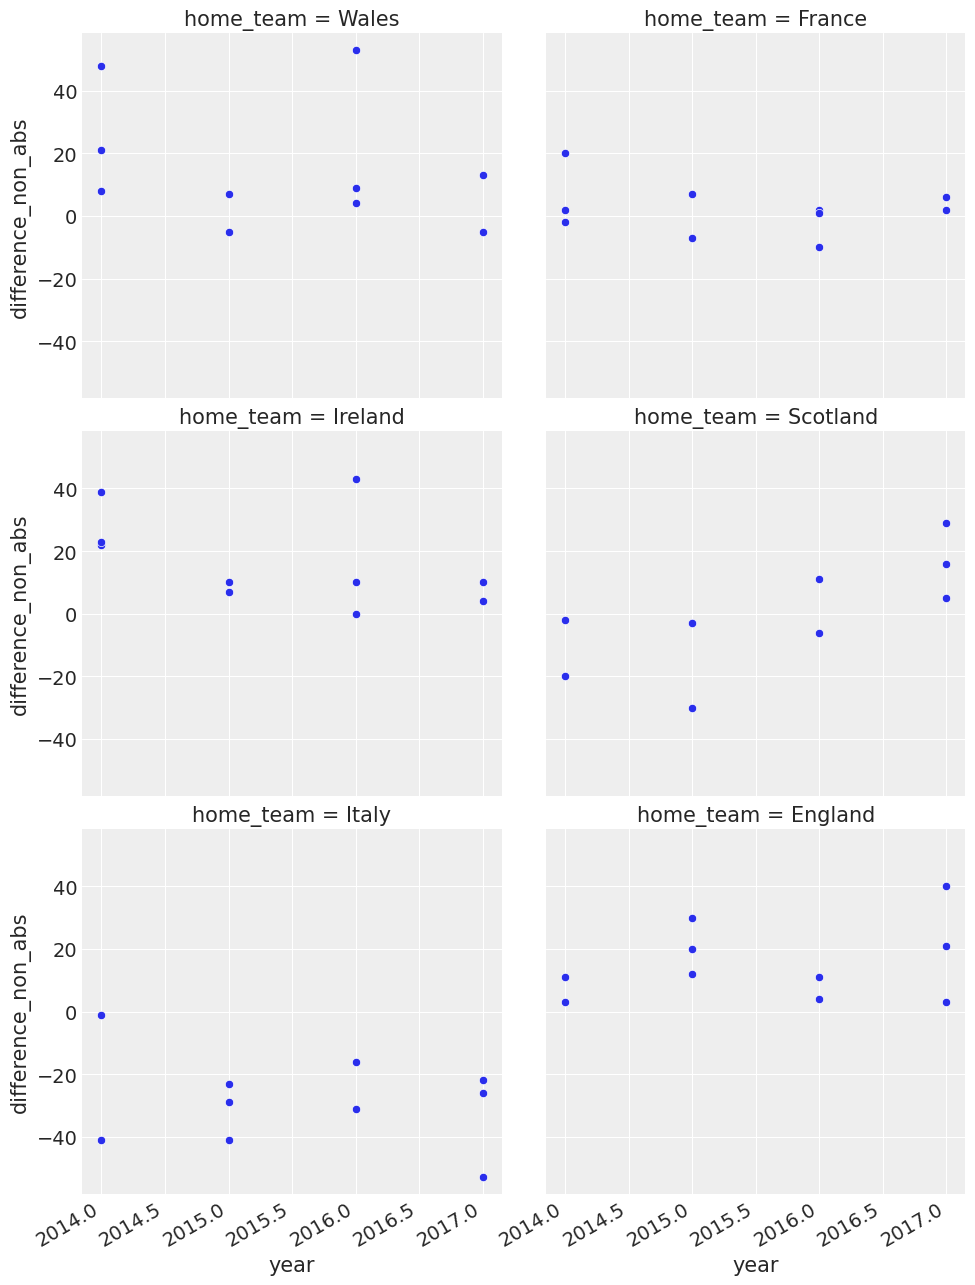

In [21]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, height=5)
g.map(sns.scatterplot, "year", "difference_non_abs")
g.fig.autofmt_xdate()

/home/arneau/anaconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


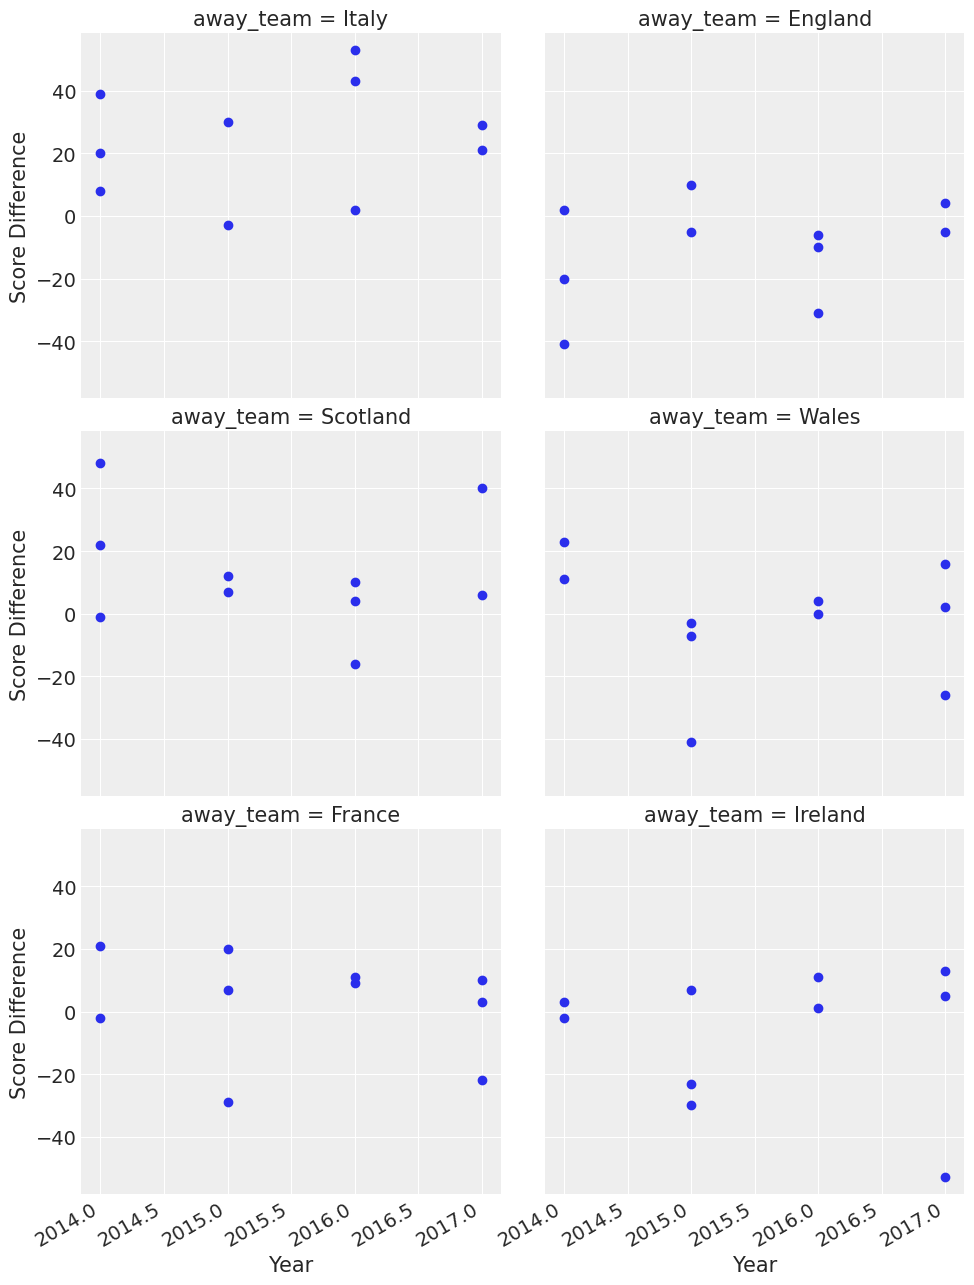

In [22]:
g = sns.FacetGrid(df_all, col="away_team", col_wrap=2, height=5)
g = g.map(plt.scatter, "year", "difference_non_abs").set_axis_labels("Year", "Score Difference")
g.fig.autofmt_xdate()

## Assumptions

- We have data from the last few years
- Sports scoring is modelled as a Poisson distribution
- home advantage to be a strong effect in sports

In [24]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [25]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.ConstantData("home_team", home_idx, dims="match")
    away_team = pm.ConstantData("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 11 seconds.
/home/arneau/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/home/arneau/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


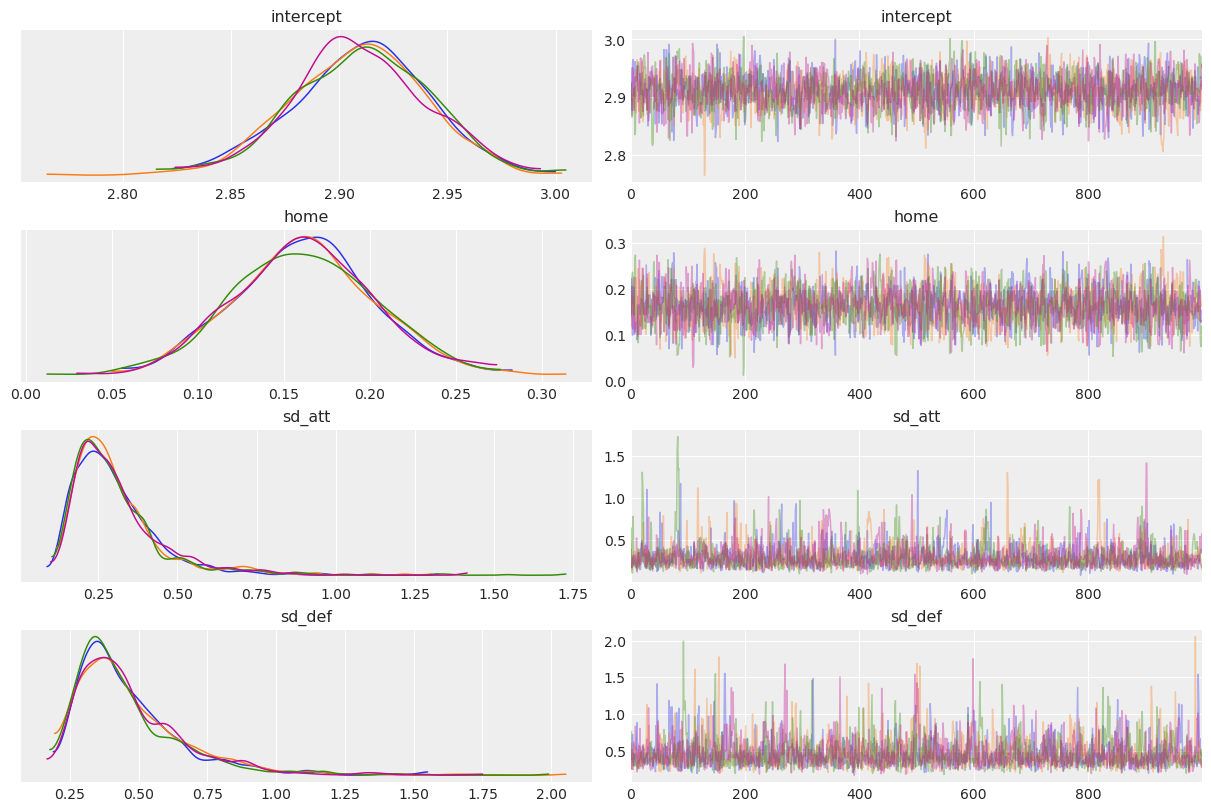

In [26]:
az.plot_trace(trace, var_names=["intercept", "home", "sd_att", "sd_def"], compact=False);

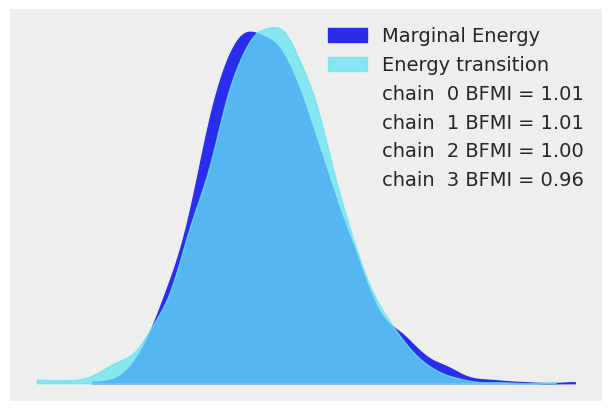

In [27]:
az.plot_energy(trace, figsize=(6, 4));

In [28]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home,0.001,0.001,2337.0,2535.0,1.0
intercept,0.001,0.000,2383.0,2718.0,1.0
atts_star[England],0.004,0.003,1474.0,1288.0,1.0
atts_star[France],0.004,0.004,1420.0,1312.0,1.0
atts_star[Ireland],0.004,0.004,1428.0,1178.0,1.0
atts_star[Italy],0.004,0.003,1499.0,1298.0,1.0
atts_star[Scotland],0.004,0.003,1477.0,1341.0,1.0
atts_star[Wales],0.004,0.003,1470.0,1277.0,1.0
defs_star[England],0.006,0.005,1354.0,993.0,1.0
defs_star[France],0.006,0.005,1344.0,1061.0,1.0


In [29]:
trace_hdi = az.hdi(trace)
trace_hdi["atts"]

<xarray.DataArray 'atts' (team: 6, hdi: 2)>
array([[ 0.17765276,  0.33174903],
       [-0.16736864,  0.00244441],
       [ 0.02711846,  0.18934452],
       [-0.44139901, -0.23620462],
       [-0.20731282, -0.03184272],
       [ 0.09581715,  0.25739323]])
Coordinates:
  * team     (team) <U8 'England' 'France' 'Ireland' 'Italy' 'Scotland' 'Wales'
  * hdi      (hdi) <U6 'lower' 'higher'

In [30]:
trace.posterior["atts"].median(("chain", "draw"))

<xarray.DataArray 'atts' (team: 6)>
array([ 0.25602742, -0.08310684,  0.10864109, -0.33471709, -0.11595561,
        0.1715093 ])
Coordinates:
  * team     (team) <U8 'England' 'France' 'Ireland' 'Italy' 'Scotland' 'Wales'

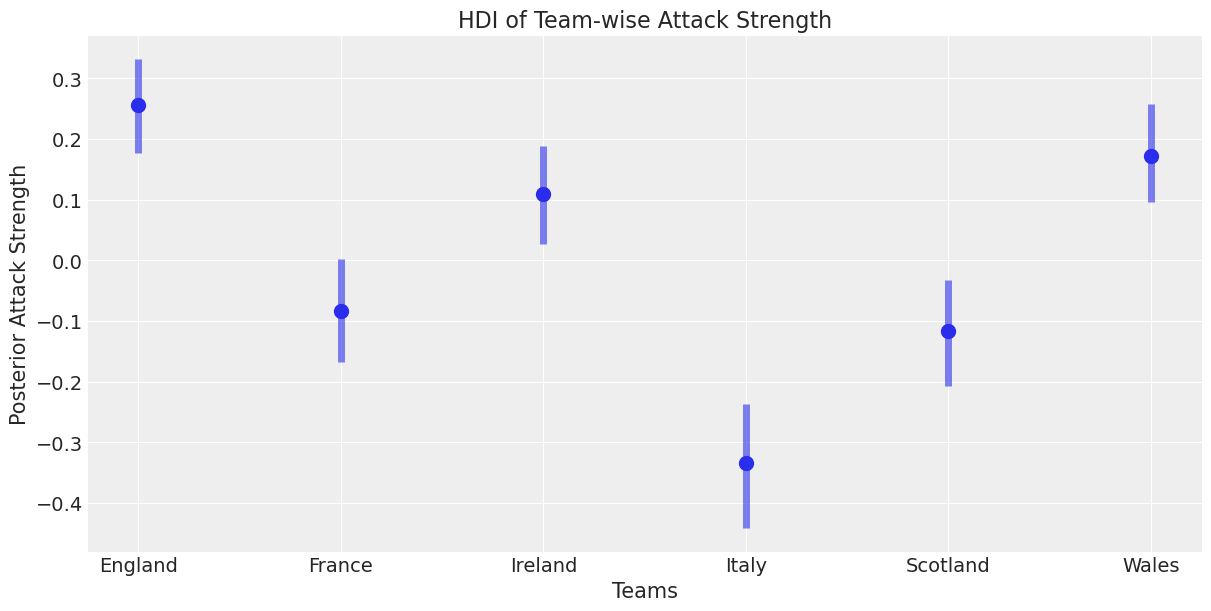

In [31]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["atts"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength");

In [32]:
# subclass arviz labeller to omit the variable name
class TeamLabeller(az.labels.BaseLabeller):
    def make_label_flat(self, var_name, sel, isel):
        sel_str = self.sel_to_str(sel, isel)
        return sel_str

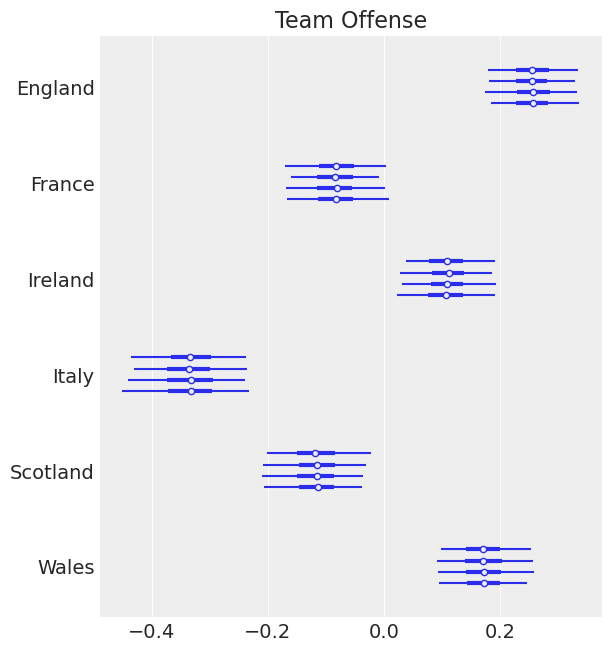

In [33]:
ax = az.plot_forest(trace, var_names=["atts"], labeller=TeamLabeller())
ax[0].set_title("Team Offense");

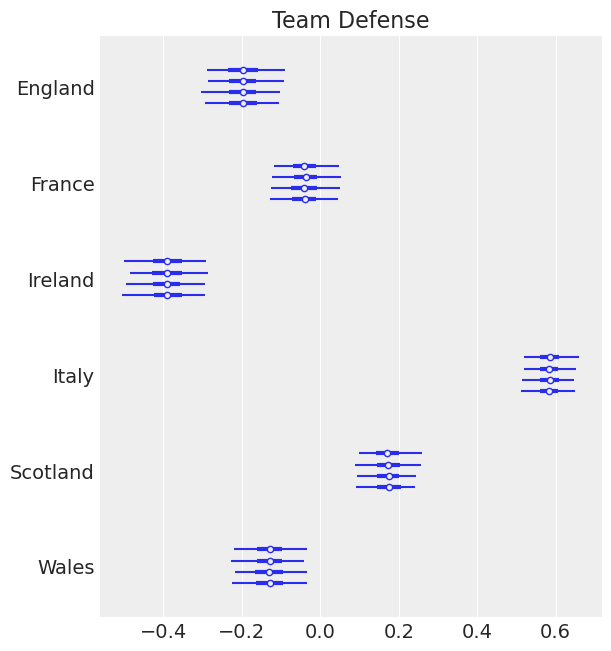

In [34]:
ax = az.plot_forest(trace, var_names=["defs"], labeller=TeamLabeller())
ax[0].set_title("Team Defense");

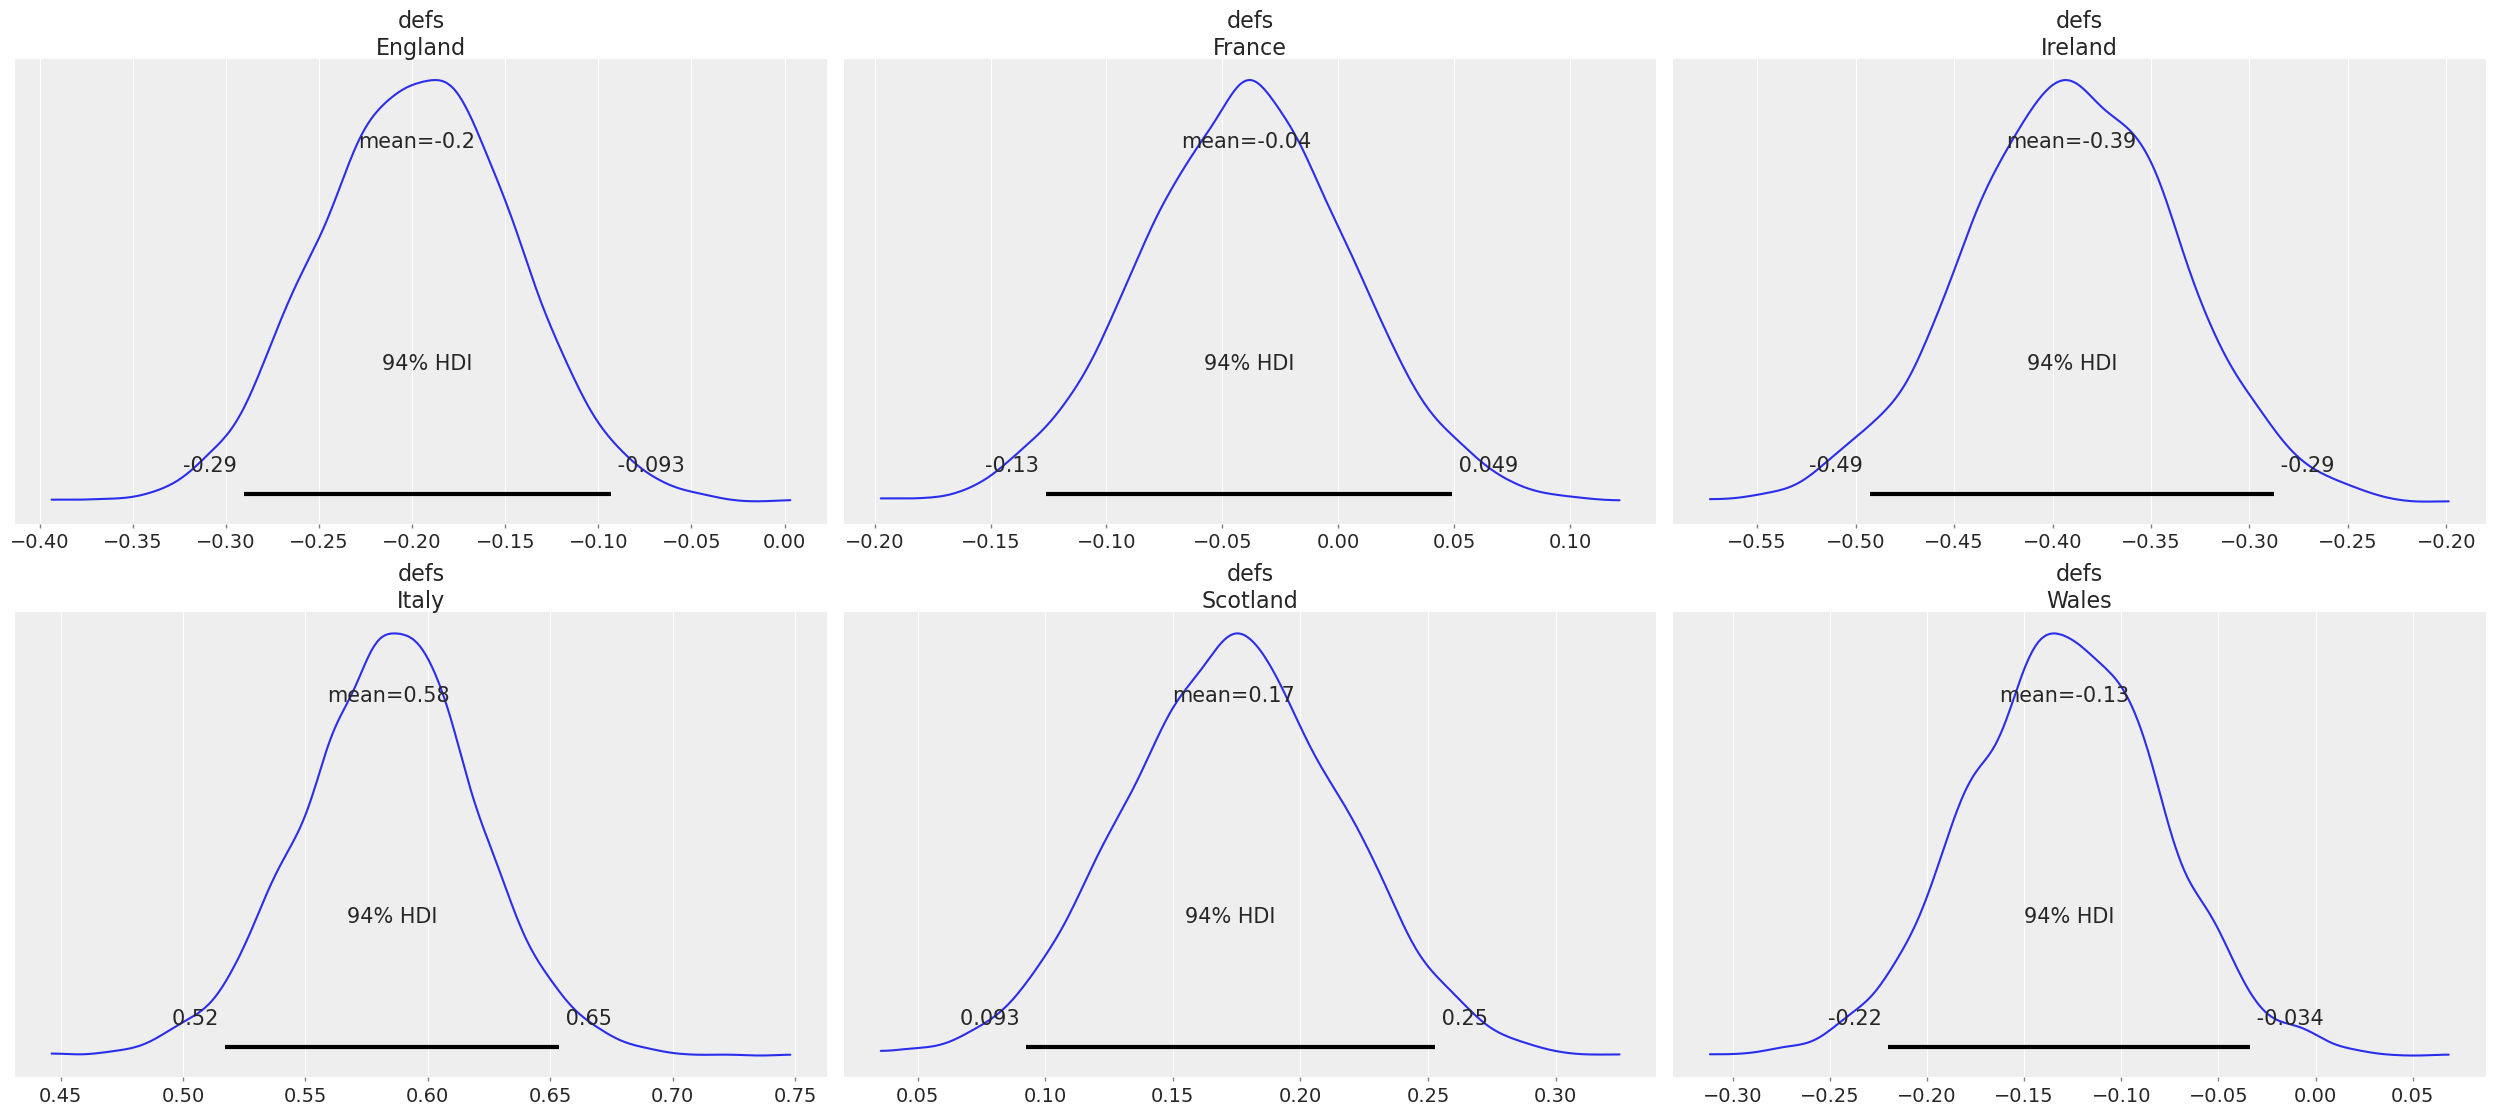

In [35]:
az.plot_posterior(trace, var_names=["defs"]);

In [36]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
pp = trace.posterior_predictive
const = trace.constant_data
team_da = trace.posterior.team

Sampling: [away_points, home_points]


In [37]:
# fmt: off
pp["home_win"] = (
        (pp["home_points"] > pp["away_points"]) * 3     # home team wins and gets 3 points
        + (pp["home_points"] == pp["away_points"]) * 2  # tie -> home team gets 2 points
)
pp["away_win"] = (
        (pp["home_points"] < pp["away_points"]) * 3
        + (pp["home_points"] == pp["away_points"]) * 2
)
# fmt: on

In [38]:
groupby_sum_home = pp.home_win.groupby(team_da[const.home_team]).sum()
groupby_sum_away = pp.away_win.groupby(team_da[const.away_team]).sum()

pp["teamscores"] = groupby_sum_home + groupby_sum_away

In [39]:
from xarray_einstats.stats import rankdata

pp["rank"] = rankdata(-pp["teamscores"], dims="team", method="min")
pp[["rank"]].sel(team="England")

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    team     <U7 'England'
Data variables:
    rank     (chain, draw) int64 2 2 2 2 3 1 1 1 1 1 1 ... 1 2 1 2 2 2 2 1 3 1 2
Attributes:
    created_at:                 2023-07-11T18:43:54.797424
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.0

In [40]:
from xarray_einstats.numba import histogram

bin_edges = np.arange(7) + 0.5
data_sim = (
    histogram(pp["rank"], dims=("chain", "draw"), bins=bin_edges, density=True)
    .rename({"bin": "rank"})
    .assign_coords(rank=np.arange(6) + 1)
)

In [41]:
idx_dim, col_dim = data_sim.dims
sim_table = pd.DataFrame(data_sim, index=data_sim[idx_dim], columns=data_sim[col_dim])

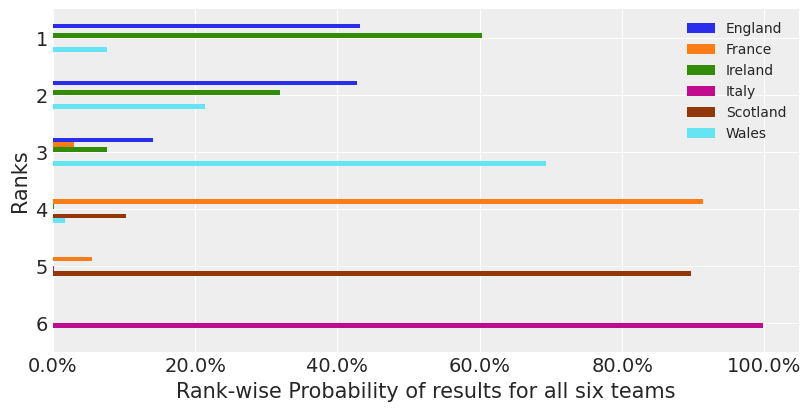

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sim_table.T.plot(kind="barh", ax=ax)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_xlabel("Rank-wise Probability of results for all six teams")
ax.set_yticklabels(np.arange(1, 7))
ax.set_ylabel("Ranks")
ax.invert_yaxis()
ax.legend(loc="best", fontsize="medium");

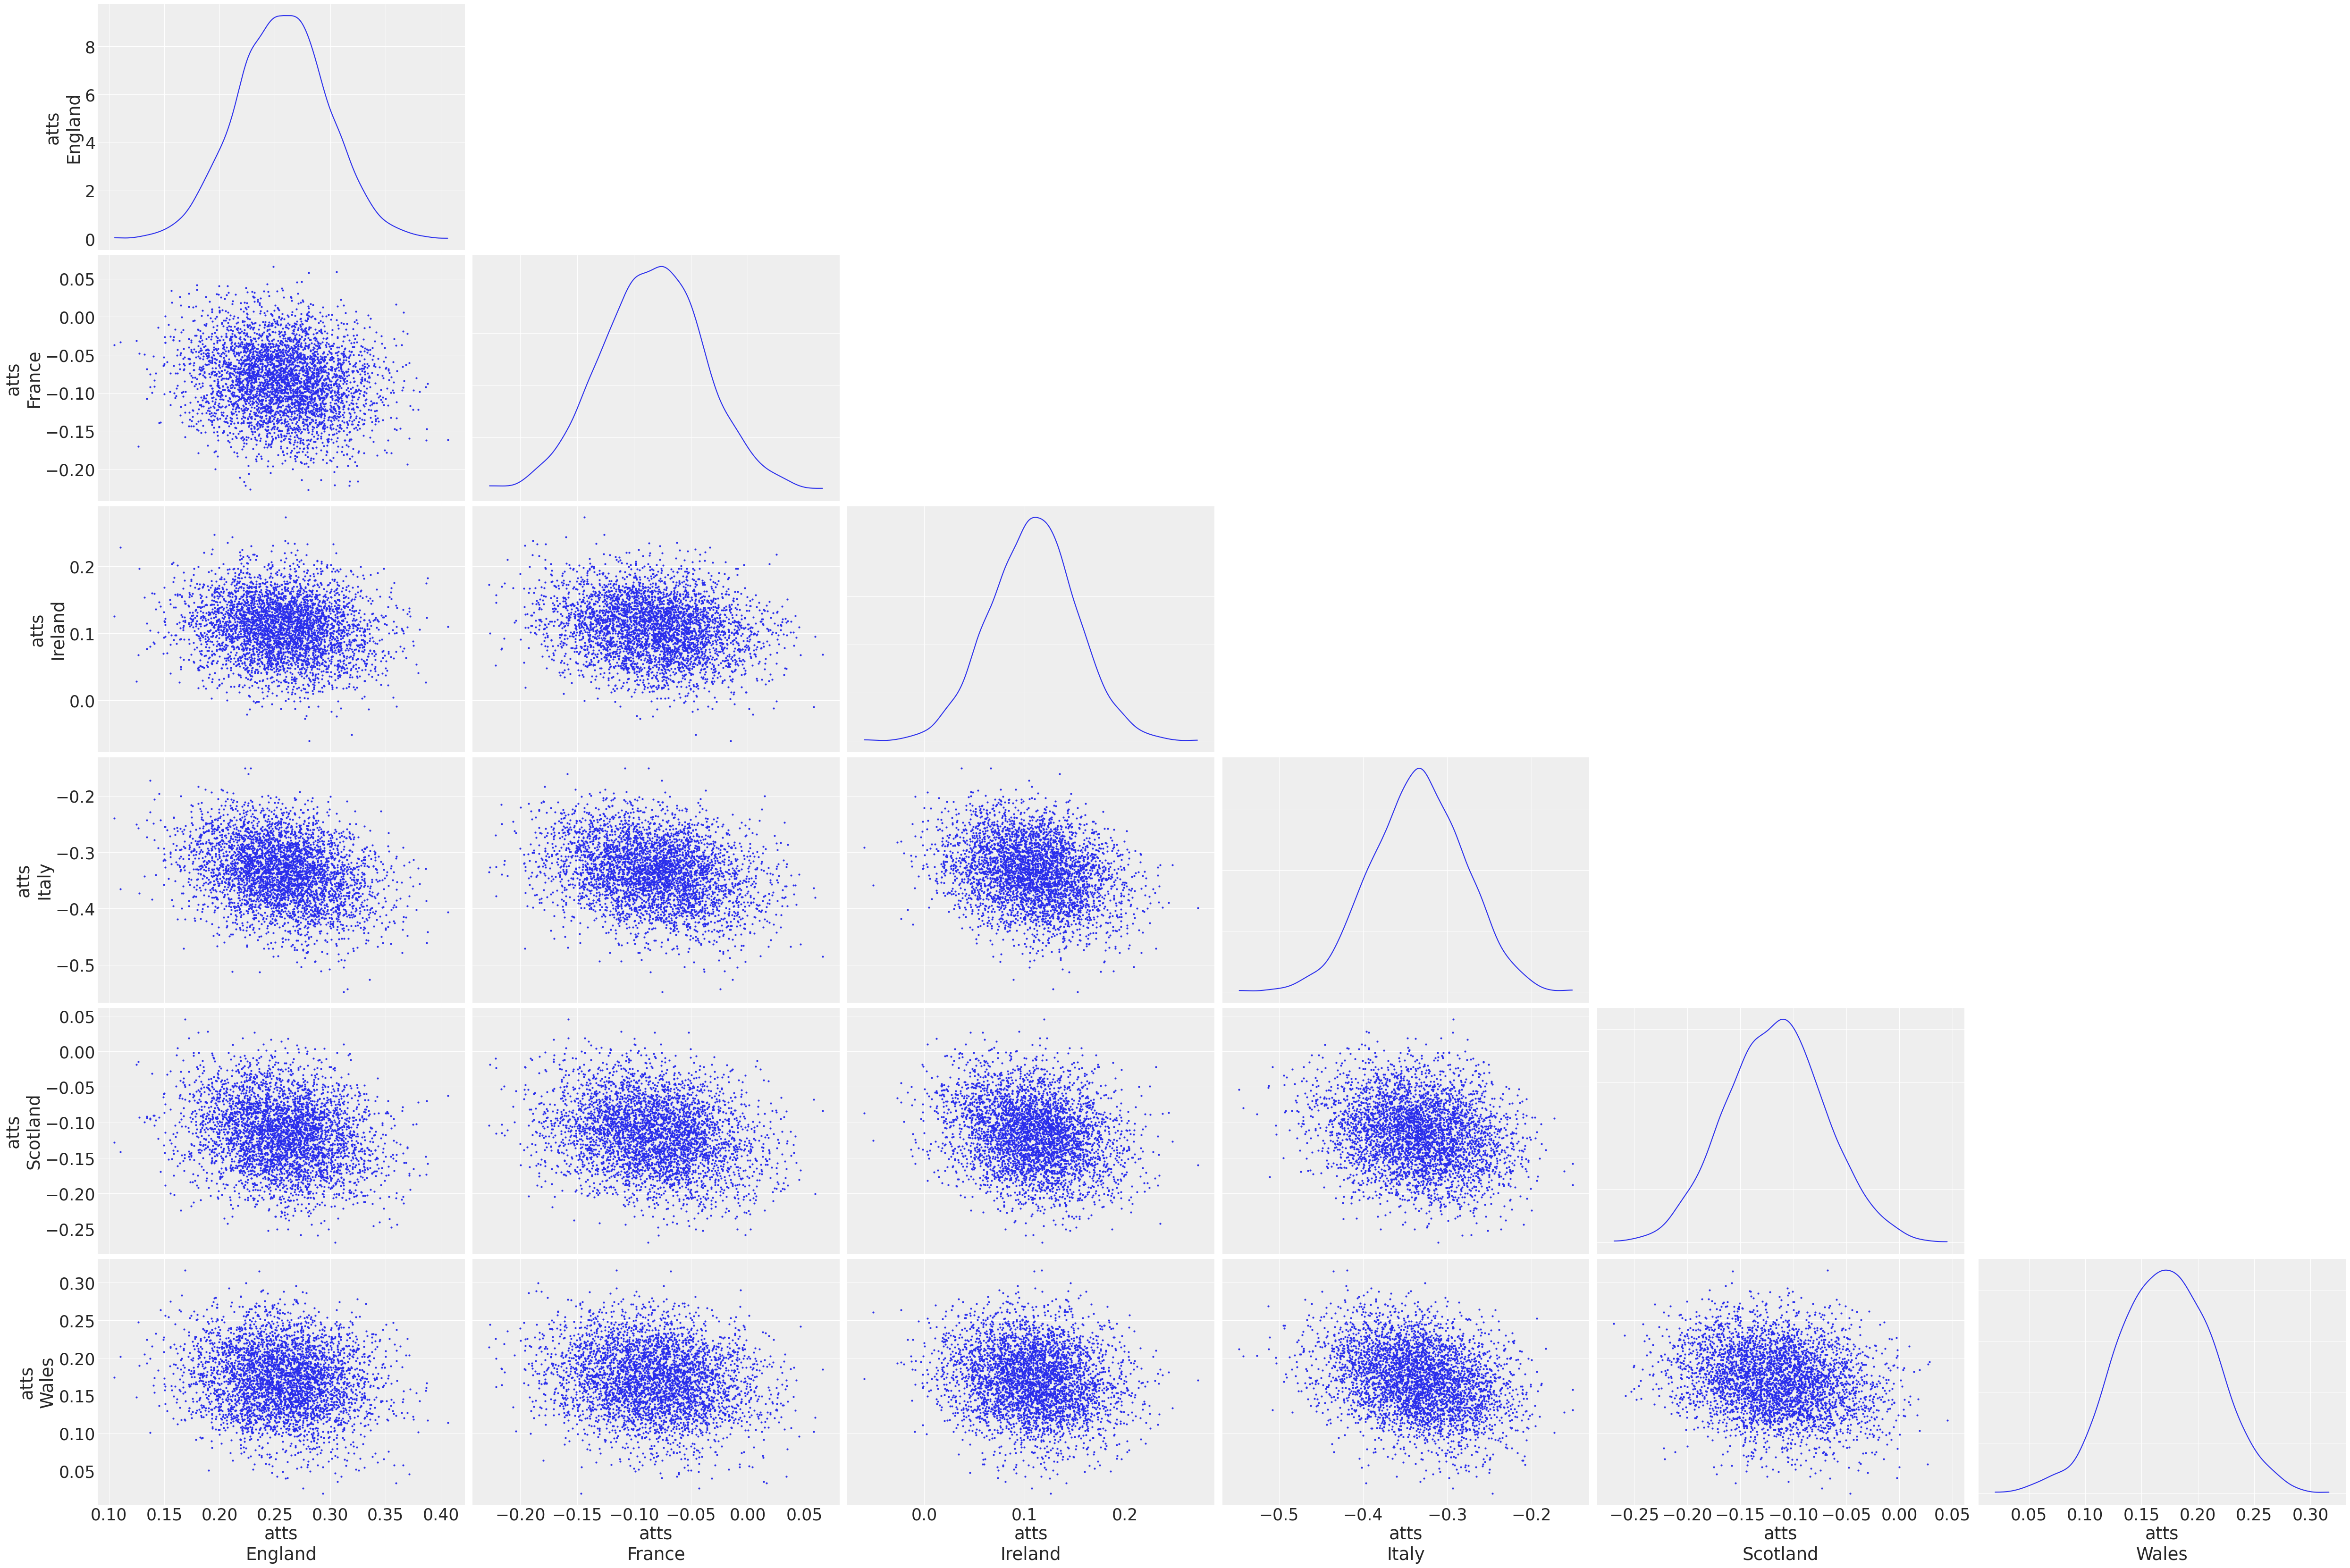

In [43]:
az.plot_pair(
    trace,
    var_names=["atts"],
    kind="scatter",
    divergences=True,
    textsize=25,
    marginals=True,
),
figsize = (10, 10)